# Retrieving OpenStreetMap data for the MIKSERI project - DEMO

This demo notebook is a simplified version of the workflow for downloading POI data form OpenStreetMap from the MIKSERI-project case areas. 

Sources / References: 

- © OpenStreetMap contributors 2021. (see [OSM copyright and license](https://www.openstreetmap.org/copyright))
- [osmnx](https://osmnx.readthedocs.io/en/stable/) (version 1.0.1) Python package + Boeing 2017 ([link to article available on  research gate](https://www.researchgate.net/publication/309738462_OSMNX_New_Methods_for_Acquiring_Constructing_Analyzing_and_Visualizing_Complex_Street_Networks))
- AutoGIS 2020 materials [autogis.github.io](autogis.github.io) and/or Tenkanen, Heikinheimo & Whipp 2021 (soon to be) available at [pythongis.org](pythongis.org)

## Introduction

### MIKSERI project

The MIKSERI-project (*Lähiympäristöjen kehittäminen kaupunkikudosten ja toiminnallisen sekoittuneisuuden näkökulmasta*) focuses on urban development from the perspective of functional mixes across urban fabrics. 
[MIKSERI project description in Finnish.](https://www.syke.fi/fi-FI/Tutkimus__kehittaminen/Tutkimus_ja_kehittamishankkeet/Hankkeet/Lahiymparistojen_kehittaminen_kaupunkikudosten_ja_toiminnallisen_sekoittuneisuuden_nakokulmasta)



### OpenStreetMap

OpenStreetMap (OSM) is a free and editable worldmap available at www.openstreetmap.org. OpenStreetMap is a community effort - anyone is free to edit the map as long as they follow the commonly agreed principles (there are currently more than 4 million contributors) ([stats from OSM wiki, November 2019](http://wiki.openstreetmap.org/wiki/Stats)). OSM contains data about streets, buildings,  services and landuse. You can also sign up as a contributor if you want to edit the map. More details about OpenStreetMap and its contents are available in the [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Main_Page).

There are different ways of accessing OSM data for further analysis. This notebook introduces the use of osmnx Python package that accesses the data via the [OverPass API](http://wiki.openstreetmap.org/wiki/Overpass_API).

### OSMnx

 [OSMnx](https://github.com/gboeing/osmnx) (Boeing 2017) is a Python module that can be used to retrieve, construct, analyze, and visualize street networks from OpenStreetMap, and to retrieve data about Points of Interest (POIs) such as restaurants, schools, and lots of different kind of services. It is also easy to conduct network routing based on walking, cycling or driving by combining OSMnx functionalities with a package called [NetworkX](https://networkx.github.io/documentation/stable/).


- Boeing, G. 2017. ["OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks."](https://www.researchgate.net/publication/309738462_OSMnx_New_Methods_for_Acquiring_Constructing_Analyzing_and_Visualizing_Complex_Street_Networks) Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004

- Interview: ["Meet the developer: Introduction to OSMnx package by Geoff Boeing"](https://www.youtube.com/watch?v=Q0uxu25ddc4&list=PLs9D4XVqc6dCAhhvhZB7aHGD8fCeCC_6N).

This notebook has been tested to work with osmnx version 1.0.1 and Python 3.8 in February 2021.

## Python environment

The Python environment was set up following these steps:

1. Install Anaconda (or Miniconda) on your computer
2. Instructions for creating a conda environment including basic GIS tools is available on the [AutoGIS course page](https://autogis-site.readthedocs.io/en/latest/course-info/create-python-gis-env.html). You can use the provided [yaml file](https://raw.githubusercontent.com/Automating-GIS-processes/site/master/ci/py38-GIS.yaml) (comes with some extra packages not needed in here..) for creating the environment.

In [1]:
import os
import glob
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import datetime
import time
start = time.time()

## Settings / custom functions

### Proxy server

In [3]:
# Organization-spesicif proxy settings in separate file my_proxy.py 
# Might be needed for fetching OSM or background maps over the network.. (Comment out if not needed..)
from my_proxy import http_proxy

os.environ['http_proxy'] = http_proxy
os.environ['https_proxy'] = http_proxy

### Output folder

In [4]:
# Output folder (note, contents of this folder are ignored by git!)
out_folder = r"..\results\downloaded_pois"

if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    print("created", out_folder)
    
else: 
    print(out_folder, "exists.")

created ..\results\downloaded_pois


#### Read in case area polygons from this repository

In [5]:
case_areas_fp = r"..\case_areas\MIKSERI_case_areas.geojson"
case_areas = gpd.read_file(r"..\case_areas\MIKSERI_case_areas.geojson")

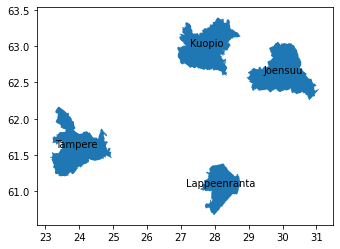

In [6]:
ax = case_areas.plot()

#Add names to plot to verify they went into correct polygons :D
case_areas.apply(lambda x: ax.annotate(text=x["name"], 
                                       xy=x.geometry.centroid.coords[0], 
                                       ha='center'),axis=1);

#### Projection

The polygons need to be in WGS84 (EPSG:4326) for osmnx.

In [7]:
case_areas.crs.name

'WGS 84'

In [8]:
# Ensure that epsg:4326 (in the default case, this is not needed, but no harm to reproject to existing crs)
case_areas = case_areas.to_crs(epsg=4326)

In [9]:
case_areas.crs.name

'WGS 84'

In [10]:
case_areas.head()

,Id,name,geometry
0,0,Lappeenranta,"POLYGON ((28.39794 61.28469, 28.50437 61.24140..."
1,0,Tampere,"POLYGON ((23.53773 62.11831, 23.64280 62.07404..."
2,0,Joensuu,"POLYGON ((29.87627 63.05832, 29.89825 63.04779..."
3,0,Kuopio,"POLYGON ((28.13315 63.38698, 28.13457 63.38592..."


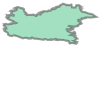

In [11]:
# Demo with one case; 0=Lappeenranta;1=Tampere, 2=Joensuu, 3=Kuopio
case = case_areas.loc[3]
case.geometry

In [12]:
case

Id                                                          0
name                                                   Kuopio
geometry    POLYGON ((28.13315142426847 63.38697654903667,...
Name: 3, dtype: object

## Example - fetch data for one case area
Point-of-interest (POI) is a generic concept that describes point locations that represent places of interest. 
In OpenStreetMap, many POIs are described using the [amenity-tags](https://wiki.openstreetmap.org/wiki/Key:amenityhttps://wiki.openstreetmap.org/wiki/Key:amenity). 
We can, for excample, retrieve all restaurat locations by referring to the tag `amenity=restaurant`. See all available amenity categories from [OSM wiki](https://wiki.openstreetmap.org/wiki/Key:amenity). Various kinds of shops are tagged using [shop-tags](https://wiki.openstreetmap.org/wiki/Key:shop).

Here, we will retrieve all shops and amenities for further inspection.

In [13]:
# List key-value pairs for tags
#tags = {'amenity': 'restaurant'}
tags = {"amenity": True, 'shop':True, 'tourism':True}

# Retrieve restaurants
pois = ox.geometries_from_polygon(case.geometry, tags)

# Check the result
len(pois)

2862

Let's explore what kind of attributes we have in our GeoDataFrame:

In [14]:
pois.head(2)

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,element_type,amenity,geometry,addr:city,addr:country,name,religion,is_in,...,dog,reservation,sanitary_dump_station,shower,building:architecture,backcountry,place,produce,facebook,drive_through:covid19
0,node/34980260,34980260,node,parking,POINT (27.62741 62.88878),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/34980285,34980285,node,parking,POINT (27.62989 62.88945),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Available columns
#print(pois.columns.values)
len(pois.columns.values)

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


240

As you can see, there is quite a lot of (potential) information related to the amenities. Let's subset the columns and inspect the data further. Useful columns include at least `name`, `address information` and `opening_hours` information:

In [16]:
# Select some useful cols and print
cols = ['name', 'name:fi', 'amenity','shop','tourism','opening_hours', 
        'addr:city', 'addr:country', 'addr:housenumber', 'addr:postcode', 'addr:street', 
        'leisure', 'website']

# Print only selected cols
pois[cols].head()

,name,name:fi,amenity,shop,tourism,opening_hours,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,leisure,website
0,NaN,NaN,parking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,parking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Männistön Pyhän Johanneksen Kirkko,NaN,place_of_worship,NaN,NaN,NaN,Kuopio,FI,NaN,NaN,NaN,NaN,NaN
3,Puijo,NaN,NaN,NaN,attraction,NaN,Kuopio,FI,NaN,NaN,NaN,NaN,NaN
4,Savon Pizza-Kebab,NaN,restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print(pois.amenity.value_counts().head(15))

parking             1232
restaurant           106
school                77
bench                 74
shelter               61
social_facility       53
fast_food             51
fuel                  51
kindergarten          46
place_of_worship      39
bicycle_rental        37
cafe                  37
pub                   28
post_box              27
waste_basket          26
Name: amenity, dtype: int64


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
print(pois.tourism.value_counts().head(15))

picnic_site        42
information        42
artwork            30
museum             20
viewpoint          17
hotel              17
attraction         12
chalet             11
hostel              5
camp_site           4
guest_house         4
caravan_site        3
apartment hotel     3
gallery             2
wilderness_hut      1
Name: tourism, dtype: int64


In [19]:
print("shops:", len(pois[pois.shop.notnull()]))
print("amenities:", len(pois[pois.amenity.notnull()]))
print("tourism:", len(pois[pois.tourism.notnull()]))

shops: 402
amenities: 2261
tourism: 214


In [20]:
pois.head()

,unique_id,osmid,element_type,amenity,geometry,addr:city,addr:country,name,religion,is_in,...,dog,reservation,sanitary_dump_station,shower,building:architecture,backcountry,place,produce,facebook,drive_through:covid19
0,node/34980260,34980260,node,parking,POINT (27.62741 62.88878),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/34980285,34980285,node,parking,POINT (27.62989 62.88945),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/162657407,162657407,node,place_of_worship,POINT (27.69370 62.90690),Kuopio,FI,Männistön Pyhän Johanneksen Kirkko,christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/197391072,197391072,node,NaN,POINT (27.65611 62.90950),Kuopio,FI,Puijo,NaN,"Kuopio, Finland",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/197420228,197420228,node,restaurant,POINT (27.70601 62.91659),NaN,NaN,Savon Pizza-Kebab,NaN,"Kelloniemi, Kuopio, Finland",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Result includes also polygons, we can restrict the result based on the geometry type
#pois[pois["geometry"].type=="Point"]

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Handle polygons (note, this might introduce duplicates into the data!)

In [22]:
pois.loc[pois["geometry"].type=="Point", "source"] = "OSM_point"
pois.loc[pois["geometry"].type=="Polygon", "source"] = "OSM_polygon"

# Approximate polygon location using a point centroid 
# Calculate centroid on-the-fly using a local projection (EPSG:3067)
poly_centroids = pois.loc[pois["geometry"].type=="Polygon"].to_crs(3067).centroid.to_crs(4326)
pois.loc[pois["geometry"].type=="Polygon", "geometry"] = poly_centroids

In [23]:
pois.head()


,unique_id,osmid,element_type,amenity,geometry,addr:city,addr:country,name,religion,is_in,...,dog,reservation,sanitary_dump_station,shower,building:architecture,backcountry,place,produce,facebook,drive_through:covid19
0,node/34980260,34980260,node,parking,POINT (27.62741 62.88878),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/34980285,34980285,node,parking,POINT (27.62989 62.88945),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/162657407,162657407,node,place_of_worship,POINT (27.69370 62.90690),Kuopio,FI,Männistön Pyhän Johanneksen Kirkko,christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/197391072,197391072,node,NaN,POINT (27.65611 62.90950),Kuopio,FI,Puijo,NaN,"Kuopio, Finland",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/197420228,197420228,node,restaurant,POINT (27.70601 62.91659),NaN,NaN,Savon Pizza-Kebab,NaN,"Kelloniemi, Kuopio, Finland",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, there is a lot of  information available. Also, if some of the information need updating, you can go over to www.openstreetmap.org and edit the source data! :)

In [24]:
meantime = time.time()
current_time = str(datetime.timedelta(seconds=round(meantime - start, 0)))
print("Notebook execution time so far: ", current_time)

Notebook execution time so far:  0:02:12


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualize

Simple maps for quick visual check

(2994786.2243453255, 3162056.8994149123, 9032675.817065887, 9184652.635794664)

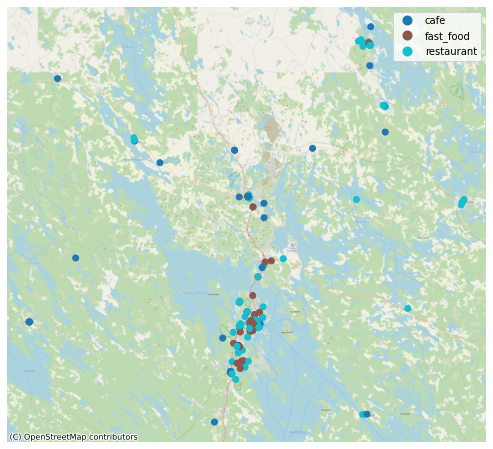

In [25]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(12,8))

data = pois[pois.amenity.isin(["restaurant", "fast_food", "cafe"])].copy()

#Re-project for plotting with basemap
data = data.to_crs(epsg=3857)

# Fetch amenities 
data.plot(ax=ax, column="amenity", legend=True)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.axis("off")

#plt.savefig(os.path.join("..\img", layername + ".png"), dpi=300)

In [26]:
meantime = time.time()
current_time = str(datetime.timedelta(seconds=round(meantime - start, 0)))
print("Notebook execution time so far: ", current_time)

Notebook execution time so far:  0:02:19


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Next steps

- Manual check of data quality (start with potential duplicates)
- Edit data over at www.openstreetmap.org and fetch again or do custom edits locally. 
- Proceed to accessibility analysis 